--- Running experiment for seed: 1 ---
--- Running experiment for seed: 2 ---
--- Running experiment for seed: 3 ---
--- Running experiment for seed: 4 ---
--- Running experiment for seed: 5 ---
--- Running experiment for seed: 6 ---
--- Running experiment for seed: 7 ---
--- Running experiment for seed: 8 ---
--- Running experiment for seed: 9 ---
--- Running experiment for seed: 10 ---
--- Running experiment for seed: 11 ---
--- Running experiment for seed: 12 ---
--- Running experiment for seed: 13 ---
--- Running experiment for seed: 14 ---
--- Running experiment for seed: 15 ---
--- Running experiment for seed: 16 ---
--- Running experiment for seed: 17 ---
--- Running experiment for seed: 18 ---
--- Running experiment for seed: 19 ---
--- Running experiment for seed: 20 ---


                    AGGREGATED RESULTS ACROSS ALL SEEDS
    seed  Strategic_Non-Strategic_Acc  Strategic_Strategic_Acc  Vanilla_Non-Strategic_Acc  Vanilla_Strategic_Acc
0      1                       0.2240 

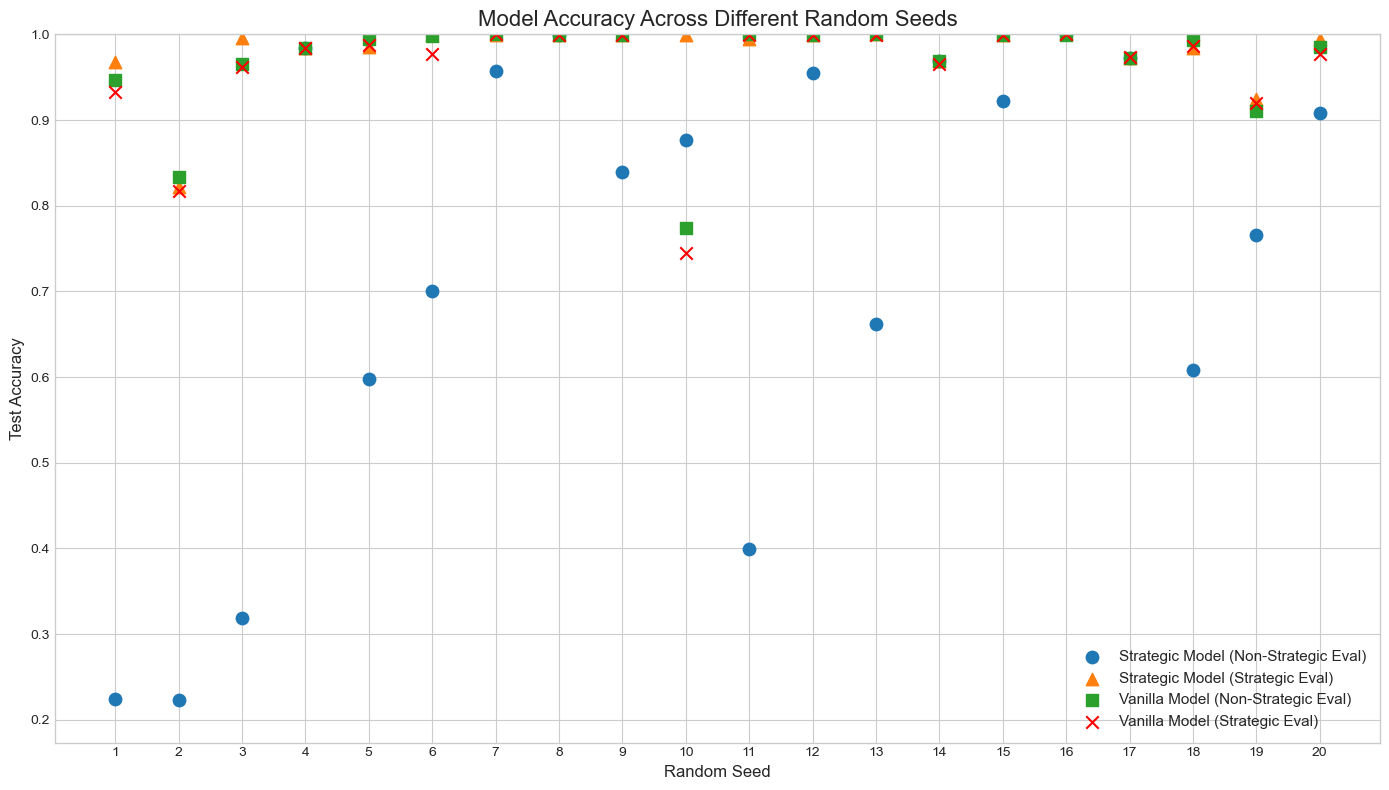

In [1]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# --- 1. Model Architecture (No changes here) ---
class BaseModel:
    def __init__(self):
        self.w_A = None; self.w_B = None
    def _prepare_features(self, X, Z=None):
        X_b = np.c_[np.ones(X.shape[0]), X]
        if Z is not None: XZ_b = np.c_[X_b, Z]; return XZ_b, X_b
        return None, X_b

    def predict_A(self, X, Z):
        XZ_b, _ = self._prepare_features(X, Z); logits = XZ_b @ self.w_A
        prediction = np.sign(logits); prediction[prediction == 0] = 1; return prediction
    def predict_B(self, X):
        _, X_b = self._prepare_features(X); logits = X_b @ self.w_B
        prediction = np.sign(logits); prediction[prediction == 0] = 1; return prediction

    def get_strategic_choice_and_prediction(self, X, Z):
        XZ_b, X_b = self._prepare_features(X, Z)
        logits_A = XZ_b @ self.w_A
        logits_B = X_b @ self.w_B
        pred_A = np.sign(logits_A); pred_A[pred_A == 0] = 1
        pred_B = np.sign(logits_B); pred_B[pred_B == 0] = 1
        final_prediction = np.zeros(X.shape[0], dtype=int)
        choice_is_A = np.zeros(X.shape[0], dtype=bool)
        both_predict_pos = (pred_A == 1) & (pred_B == 1)
        final_prediction[both_predict_pos] = 1
        choice_is_A[both_predict_pos] = True
        only_A_predict_pos = (pred_A == 1) & (pred_B == -1)
        final_prediction[only_A_predict_pos] = 1
        choice_is_A[only_A_predict_pos] = True
        only_B_predict_pos = (pred_A == -1) & (pred_B == 1)
        final_prediction[only_B_predict_pos] = 1
        choice_is_A[only_B_predict_pos] = False
        both_predict_neg = (pred_A == -1) & (pred_B == -1)
        final_prediction[both_predict_neg] = -1
        choice_is_A[both_predict_neg] = True
        return final_prediction, choice_is_A

    def predict_strategic_with_choice(self, X, Z):
        prediction, choice_is_A = self.get_strategic_choice_and_prediction(X, Z)
        color_grid = np.zeros_like(prediction, dtype=int)
        color_grid[(prediction == 1) & choice_is_A] = 2
        color_grid[(prediction == 1) & ~choice_is_A] = 1
        color_grid[(prediction == -1) & ~choice_is_A] = -1
        color_grid[(prediction == -1) & choice_is_A] = -2
        return color_grid

    def evaluate(self, X, Y, Z, strategic=False):
        if not strategic:
            XZ_b, _ = self._prepare_features(X, Z)
            final_logits = XZ_b @ self.w_A
        else:
            final_logits, _ = self.get_strategic_choice_and_prediction(X, Z)
        y_pred = np.sign(final_logits)
        y_pred[y_pred == 0] = 1
        return accuracy_score(Y, y_pred)

    def _logistic_loss(self, y_true, logits): return np.mean(np.log(1 + np.exp(-y_true * logits)))

class StrategicModel(BaseModel):
    def __init__(self, optimizer_method='Nelder-Mead', optimizer_maxiter=500, optimizer_disp=False):
        super().__init__(); self.optimizer_method = optimizer_method; self.optimizer_maxiter = optimizer_maxiter; self.optimizer_disp = optimizer_disp
    def _objective(self, weights, X, Y, Z):
        self.w_A = weights[:4]; self.w_B = weights[4:]; XZ_b, X_b = self._prepare_features(X, Z)
        logits_A = XZ_b @ self.w_A; logits_B = X_b @ self.w_B
        use_A = logits_A >= logits_B
        final_logits = np.where(use_A, logits_A, logits_B); return self._logistic_loss(Y, final_logits)
    def train(self, X, Y, Z):
        initial_weights = np.zeros(7)
        result = minimize(self._objective, initial_weights, args=(X, Y, Z), method=self.optimizer_method, options={'maxiter': self.optimizer_maxiter, 'disp': self.optimizer_disp})
        self.w_A = result.x[:4]; self.w_B = result.x[4:]

class VanillaModel(BaseModel):
    def __init__(self, optimizer_method='Nelder-Mead', optimizer_maxiter=500, optimizer_disp=False):
        super().__init__(); self.optimizer_method = optimizer_method; self.optimizer_maxiter = optimizer_maxiter; self.optimizer_disp = optimizer_disp
    def _objective_A(self, w_A, XZ_b, Y): return self._logistic_loss(Y, XZ_b @ w_A)
    def _objective_B(self, w_B, X_b, Y): return self._logistic_loss(Y, X_b @ w_B)
    def train(self, X, Y, Z):
        XZ_b, X_b = self._prepare_features(X, Z)
        res_A = minimize(self._objective_A, np.zeros(4), args=(XZ_b, Y), method=self.optimizer_method, options={'maxiter': self.optimizer_maxiter, 'disp': self.optimizer_disp})
        self.w_A = res_A.x
        res_B = minimize(self._objective_B, np.zeros(3), args=(X_b, Y), method=self.optimizer_method, options={'maxiter': self.optimizer_maxiter, 'disp': self.optimizer_disp})
        self.w_B = res_B.x

class BayesianModel(BaseModel):
    def __init__(self):
        super().__init__()
        self.yz_pairs = None; self.yz_probabilities = None
        self.centers = None; self.covariances = None

    def learn_parameters_from_dataset(self, dataset: 'Dataset'):
        self.yz_pairs = dataset.yz_pairs
        self.yz_probabilities = dataset.yz_probabilities
        self.centers = dataset.centers
        self.covariances = dataset.covariances
        if hasattr(self, 'verbose') and self.verbose:
            print("\n--- Bayesian Model initialized with true generative parameters (Calculated, not learned) ---")

    def _get_joint_prob(self, y, z):
        for i, pair in enumerate(self.yz_pairs):
            if pair[0] == y and pair[1] == z:
                return self.yz_probabilities[i]
        return 0

    def predict_proba(self, X, Z):
        n_samples = X.shape[0]; prob_Y_is_1 = np.zeros(n_samples)
        for i in range(n_samples):
            x_i, z_i = X[i, :], Z[i]
            mean_y1_z, cov_y1_z = self.centers.get((1, z_i)), self.covariances.get((1, z_i))
            mean_y_neg1_z, cov_y_neg1_z = self.centers.get((-1, z_i)), self.covariances.get((-1, z_i))
            if mean_y1_z is None or mean_y_neg1_z is None:
                prob_Y_is_1[i] = 0.5; continue
            likelihood_y1 = multivariate_normal.pdf(x_i, mean=mean_y1_z, cov=cov_y1_z)
            likelihood_y_neg1 = multivariate_normal.pdf(x_i, mean=mean_y_neg1_z, cov=cov_y_neg1_z)
            joint_prob_y1_z = self._get_joint_prob(1, z_i)
            joint_prob_y_neg1_z = self._get_joint_prob(-1, z_i)
            numerator_y1 = likelihood_y1 * joint_prob_y1_z
            numerator_y_neg1 = likelihood_y_neg1 * joint_prob_y_neg1_z
            denominator = numerator_y1 + numerator_y_neg1
            prob_Y_is_1[i] = 0.5 if denominator < 1e-9 else numerator_y1 / denominator
        return prob_Y_is_1

    def predict(self, X, Z):
        prob_Y_is_1 = self.predict_proba(X, Z)
        return np.where(prob_Y_is_1 >= 0.5, 1, -1)

    def evaluate(self, X, Y, Z):
        y_pred = self.predict(X, Z)
        return accuracy_score(Y, y_pred)

# --- 2. Data Handling (No changes here) ---
class Dataset:
    def __init__(self, n_train, n_test, rng, parameter_mode='random', verbose=True):
        self.n_train = n_train; self.n_test = n_test; self.rng = rng
        self.parameter_mode = parameter_mode
        self.verbose = verbose
        self._generate_data_distribution_parameters()
        self.X_train, self.Y_train, self.Z_train = None, None, None
        self.X_test, self.Y_test, self.Z_test = None, None, None

    def _generate_data_distribution_parameters(self):
        self.yz_pairs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

        if self.parameter_mode == 'manual':
            if self.verbose: print("\n--- Using MANUALLY DEFINED Data Distribution Parameters ---")
            self.yz_probabilities = np.array([0.23, 0.27, 0.22, 0.28])
            self.centers = {
                (-1, -1): np.array([-0.6, -0.6]), (-1, 1):  np.array([-0.65, -0.55]),
                (1, -1):  np.array([-0.5, -0.6]),  (1, 1):   np.array([-0.6, 0.55])
            }
            self.covariances = {
                (-1, -1): np.array([[0.1, 0.04], [0.04, 0.08]]), (-1, 1):  np.array([[0.08, -0.04], [-0.04, 0.1]]),
                (1, -1):  np.array([[0.08, 0.04], [0.04, 0.1]]),  (1, 1):   np.array([[0.1, -0.04], [-0.04, 0.08]])
            }
        elif self.parameter_mode == 'random':
            if self.verbose: print("\n--- Using RANDOMLY GENERATED Data Distribution Parameters ---")
            self.yz_probabilities = self.rng.dirichlet(np.ones(4))
            self.centers = {tuple(p): self.rng.uniform(-0.8, 0.8, size=2) for p in self.yz_pairs}
            self.covariances = {}
            for pair in self.yz_pairs:
                A = self.rng.uniform(-0.5, 0.5, size=(2, 2)); cov = A @ A.T + np.eye(2) * 0.01
                self.covariances[tuple(pair)] = cov * self.rng.uniform(0.05, 0.15)
        else:
            raise ValueError(f"Invalid parameter_mode: {self.parameter_mode}. Must be 'manual' or 'random'.")

    def _sample_from_distribution(self, n_samples):
        yz_idx = self.rng.choice(4, size=n_samples, p=self.yz_probabilities); Y = self.yz_pairs[yz_idx, 0]; Z = self.yz_pairs[yz_idx, 1]
        X = np.zeros((n_samples, 2))
        for i in range(n_samples):
            mean = self.centers[(Y[i], Z[i])]; cov = self.covariances[(Y[i], Z[i])]
            X[i, :] = self.rng.multivariate_normal(mean, cov=cov)
        return X, Y, Z
    def generate_data(self):
        self.X_train, self.Y_train, self.Z_train = self._sample_from_distribution(self.n_train)
        self.X_test, self.Y_test, self.Z_test = self._sample_from_distribution(self.n_test)
        if self.verbose: print(f"Generated {self.n_train} training samples and {self.n_test} test samples.")

# --- 3. Experiment Orchestration (MODIFIED) ---
class Experiment:
    def __init__(self, n_train, n_test, seed, optimizer_method='Nelder-Mead', optimizer_maxiter=500, optimizer_disp=False, parameter_mode='random', verbose=True):
        self.n_train = n_train; self.n_test = n_test; self.seed = seed
        self.verbose = verbose
        self.rng = np.random.default_rng(self.seed)
        self.optimizer_method = optimizer_method; self.optimizer_maxiter = optimizer_maxiter; self.optimizer_disp = optimizer_disp
        self.dataset = Dataset(self.n_train, self.n_test, self.rng, parameter_mode, verbose=self.verbose)
        self.strategic_model = StrategicModel(optimizer_method, optimizer_maxiter, optimizer_disp)
        self.vanilla_model = VanillaModel(optimizer_method, optimizer_maxiter, optimizer_disp)
        self.bayesian_model = BayesianModel()
        self.bayesian_model.verbose = self.verbose # Pass verbose flag down

    def _print_data_parameters(self):
        print("\n--- Shared Data Generation Parameters (Seed: {}) ---".format(self.seed))
        probs_str = np.array2string(self.dataset.yz_probabilities, precision=4, suppress_small=True)
        print("P(Y,Z) for [(-1,-1), (-1,1), (1,-1), (1,1)]: {}".format(probs_str))
        print("Conditional Gaussian P(X | Y, Z):")
        for pair in self.dataset.yz_pairs:
            pair_tuple = tuple(pair)
            center, cov = self.dataset.centers[pair_tuple], self.dataset.covariances[pair_tuple]
            mean_str = np.array2string(center, precision=3, suppress_small=True, separator=',')
            cov_str = np.array2string(cov, prefix=' '*10, precision=3, suppress_small=True, separator=',').replace('\n', ' ').replace('  ', ' ')
            print(f"  (Y={pair[0]:>2}, Z={pair[1]:>2}) -> Mean: {mean_str}, Covariance: {cov_str}")

    # MODIFIED: Added a `verbose` flag and a return value
    def run_training_and_evaluation(self):
        if self.verbose: print(f"--- Generating Data for seed number {self.seed}---")
        self.dataset.generate_data()
        if self.verbose: self._print_data_parameters()

        if self.verbose: print("\n--- Training Models ---")
        self.strategic_model.train(self.dataset.X_train, self.dataset.Y_train, self.dataset.Z_train)
        self.vanilla_model.train(self.dataset.X_train, self.dataset.Y_train, self.dataset.Z_train)
        self.bayesian_model.learn_parameters_from_dataset(self.dataset)
        if self.verbose: print("Training complete.")

        if self.verbose: print("\n--- Evaluating Models ---")
        results = []
        for name, model in [('Strategic', self.strategic_model), ('Vanilla', self.vanilla_model)]:
            acc_ns = model.evaluate(self.dataset.X_test, self.dataset.Y_test, self.dataset.Z_test, strategic=False)
            acc_s = model.evaluate(self.dataset.X_test, self.dataset.Y_test, self.dataset.Z_test, strategic=True)
            results.append({'Model': name, 'Non-Strategic Acc': acc_ns, 'Strategic Acc': acc_s})

        acc_bayesian = self.bayesian_model.evaluate(self.dataset.X_test, self.dataset.Y_test, self.dataset.Z_test)
        results.append({'Model': 'Bayesian (Optimal)', 'Non-Strategic Acc': acc_bayesian, 'Strategic Acc': np.nan})

        results_df = pd.DataFrame(results).round(4)
        if self.verbose:
            print("\n--- Evaluation Results ---"); print(results_df.to_string(index=False))

        return results_df

# --- 4. New Functions for Multiple Runs and Plotting ---

def run_multiple_experiments(seeds, params):
    """
    Runs the experiment for a list of seeds and collects the key accuracy metrics.
    """
    all_results = []

    for seed in seeds:
        print(f"--- Running experiment for seed: {seed} ---")
        # Create a new experiment instance for each seed
        experiment = Experiment(
            n_train=params['n_train'],
            n_test=params['n_test'],
            seed=seed,
            optimizer_method=params['optimizer_method'],
            optimizer_maxiter=params['optimizer_maxiter'],
            optimizer_disp=params['optimizer_disp'],
            parameter_mode=params['parameter_mode'],
            verbose=False # Suppress detailed output for each run
        )

        # Run training and evaluation to get the results DataFrame for this seed
        results_df = experiment.run_training_and_evaluation()

        # Extract the 4 required values
        strat_row = results_df[results_df['Model'] == 'Strategic']
        vanilla_row = results_df[results_df['Model'] == 'Vanilla']

        result_entry = {
            'seed': seed,
            'Strategic_Non-Strategic_Acc': strat_row['Non-Strategic Acc'].iloc[0],
            'Strategic_Strategic_Acc': strat_row['Strategic Acc'].iloc[0],
            'Vanilla_Non-Strategic_Acc': vanilla_row['Non-Strategic Acc'].iloc[0],
            'Vanilla_Strategic_Acc': vanilla_row['Strategic Acc'].iloc[0],
        }
        all_results.append(result_entry)

    # Convert the list of dictionaries to a final DataFrame
    final_df = pd.DataFrame(all_results)
    return final_df

def plot_results(df):
    """
    Generates a scatter plot of the results from the multiple experiments.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot each of the four metrics
    ax.scatter(df['seed'], df['Strategic_Non-Strategic_Acc'], label='Strategic Model (Non-Strategic Eval)', marker='o', s=80)
    ax.scatter(df['seed'], df['Strategic_Strategic_Acc'], label='Strategic Model (Strategic Eval)', marker='^', s=80)
    ax.scatter(df['seed'], df['Vanilla_Non-Strategic_Acc'], label='Vanilla Model (Non-Strategic Eval)', marker='s', s=80)
    ax.scatter(df['seed'], df['Vanilla_Strategic_Acc'], label='Vanilla Model (Strategic Eval)', marker='x', s=80, c='red')

    ax.set_title('Model Accuracy Across Different Random Seeds', fontsize=16)
    ax.set_xlabel('Random Seed', fontsize=12)
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_xticks(df['seed'])
    ax.legend(fontsize=11)
    ax.set_ylim(bottom=df.iloc[:, 1:].min().min() - 0.05, top=1.0) # Adjust y-axis for clarity

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # --- Control Panel ---
    PARAMETER_MODE = 'random' # 'manual' or 'random'
    N_TRAIN = 5000
    N_TEST = 10000
    OPTIMIZER_METHOD = 'Nelder-Mead'
    OPTIMIZER_MAXITER = 2000
    OPTIMIZER_DISP = False

    # List of seeds to iterate over
    SEEDS_TO_RUN = list(range(1, 21))

    # Package parameters into a dictionary
    exp_params = {
        'n_train': N_TRAIN,
        'n_test': N_TEST,
        'optimizer_method': OPTIMIZER_METHOD,
        'optimizer_maxiter': OPTIMIZER_MAXITER,
        'optimizer_disp': OPTIMIZER_DISP,
        'parameter_mode': PARAMETER_MODE
    }

    # --- Run the batch experiment and get the numerical results ---
    results_table = run_multiple_experiments(SEEDS_TO_RUN, exp_params)

    # --- Display the collected numerical data ---
    print("\n\n" + "="*80)
    print(" " * 20 + "AGGREGATED RESULTS ACROSS ALL SEEDS")
    print("="*80)
    # Set pandas display options to show all columns and round the output
    pd.set_option('display.width', 120)
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(results_table)
    print("="*80)

    # --- (Optional) Visualize the results as a scatter plot ---
    print("\nGenerating scatter plot of the results...")
    plot_results(results_table)